In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
sys.path.append('./src')
sys.path.append('..')

In [7]:
from src.data.gaussian_to_swiss_roll import (
    DiscreteGaussianDataset, 
    DiscreteSwissRollDataset, 
    DiscreteUniformDataset,
)
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from tqdm.notebook import tqdm
import wandb
from PIL import Image
import numpy as np

from LightSB_D import LightSB_D


In [15]:
import matplotlib
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.frombuffer  ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf    
    
def fig2img ( fig ):
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.frombytes( "RGBA", ( w ,h ), buf.tobytes( ) ) 

In [16]:
DIM          = 2
N_CAT        = 50
N_POTENTIALS = 10
D_LR         = 1e-4
DEVICE       = 'cuda:0'
BATCH_SIZE   = 512
N_EPOCHS     = 200000
TRANSITION   = 'uniform'
P0           = 'gaussian'
wandb_report = False

if TRANSITION == 'uniform':
    BETAS        = [0.001, 0.01, 0.1, 0.5, 1]
else:
    BETAS        = [0.1, 0.5, 1, 5, 10]
    

config = dict(DIM          = DIM,
              N_CAT        = N_CAT,
              N_POTENTIALS = N_POTENTIALS,
              D_LR         = D_LR,
              DEVICE       = DEVICE,
              BATCH_SIZE   = BATCH_SIZE,
              BETA         = BETAS, 
              TRANSITION   = TRANSITION,
              N_EPOCHS     = N_EPOCHS)

if wandb_report:
    wandb_mode = 'online' #'disabled'
else:
    wandb_mode = 'disabled'



  0%|          | 0/200000 [00:00<?, ?it/s]

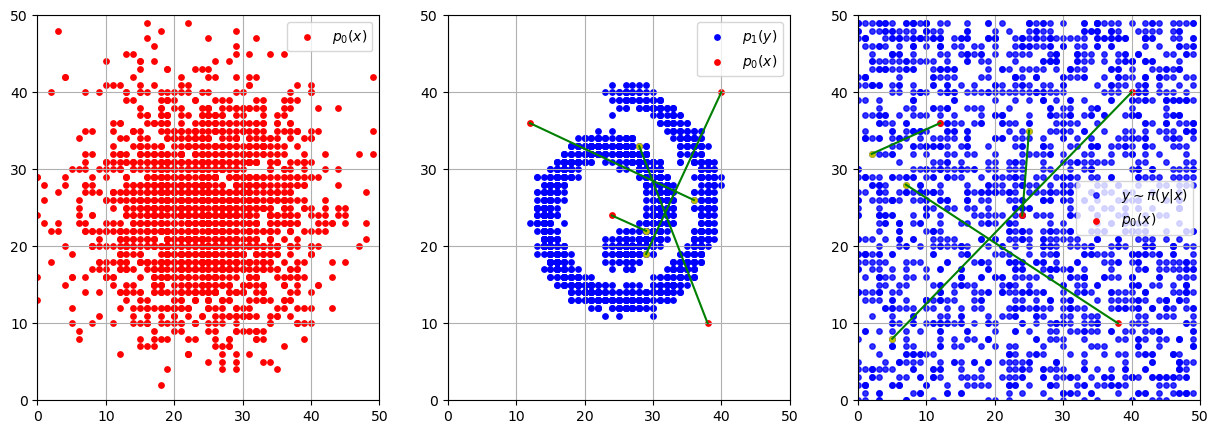

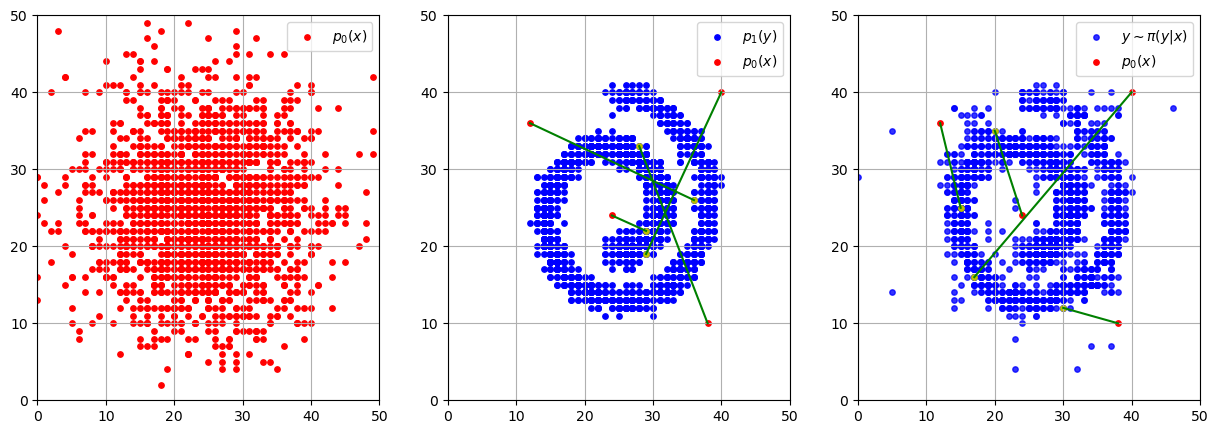

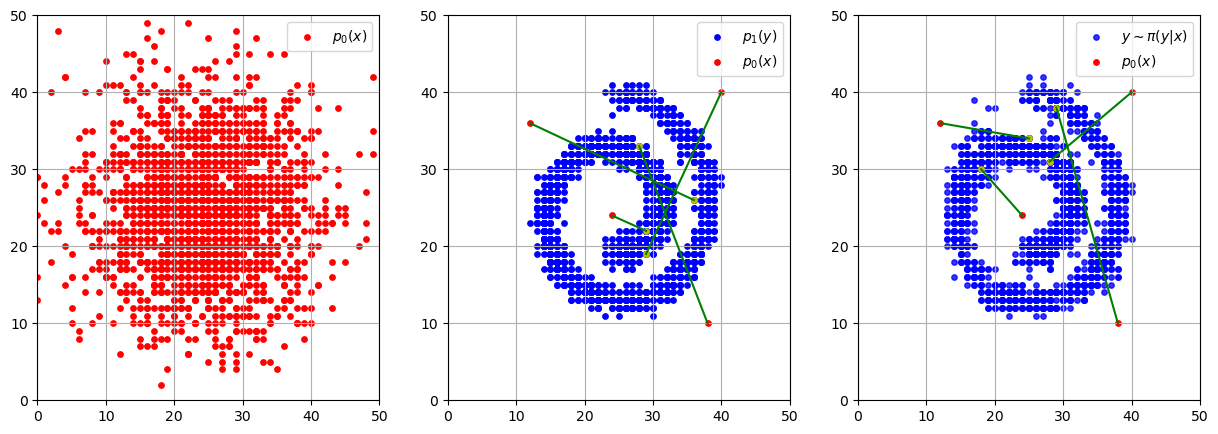

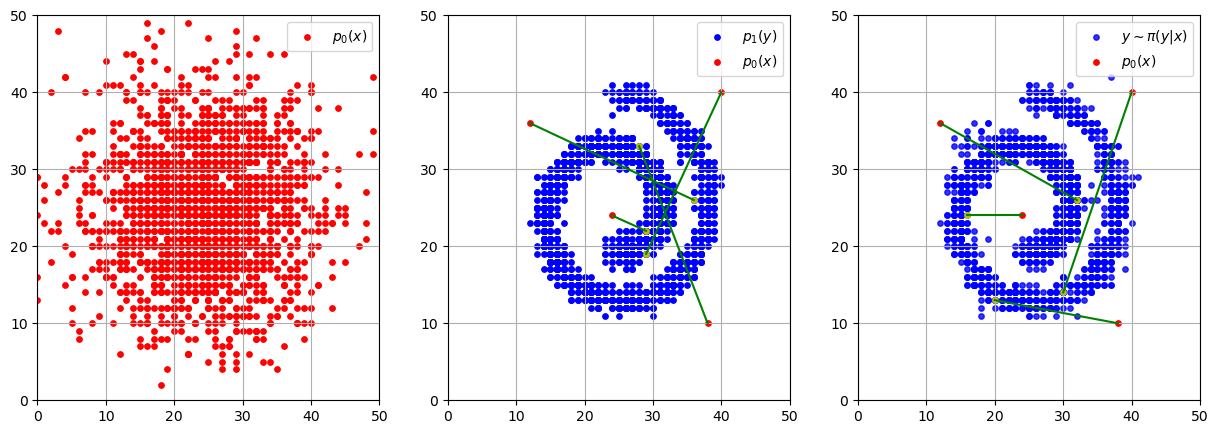

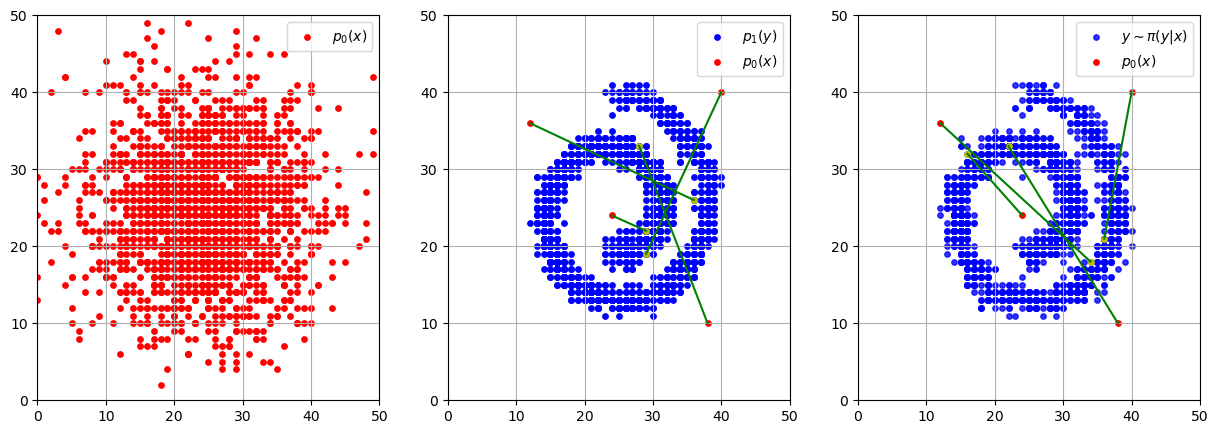

  0%|          | 0/200000 [00:00<?, ?it/s]

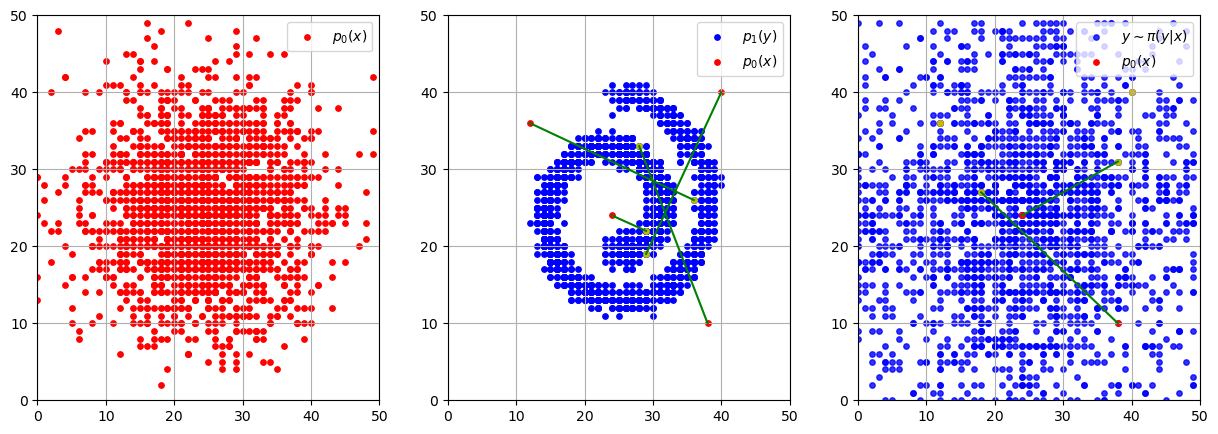

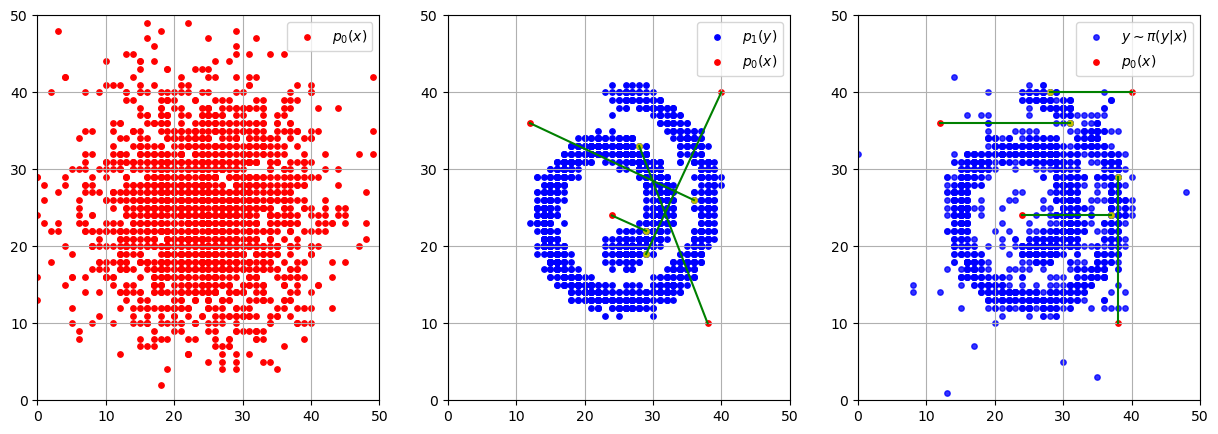

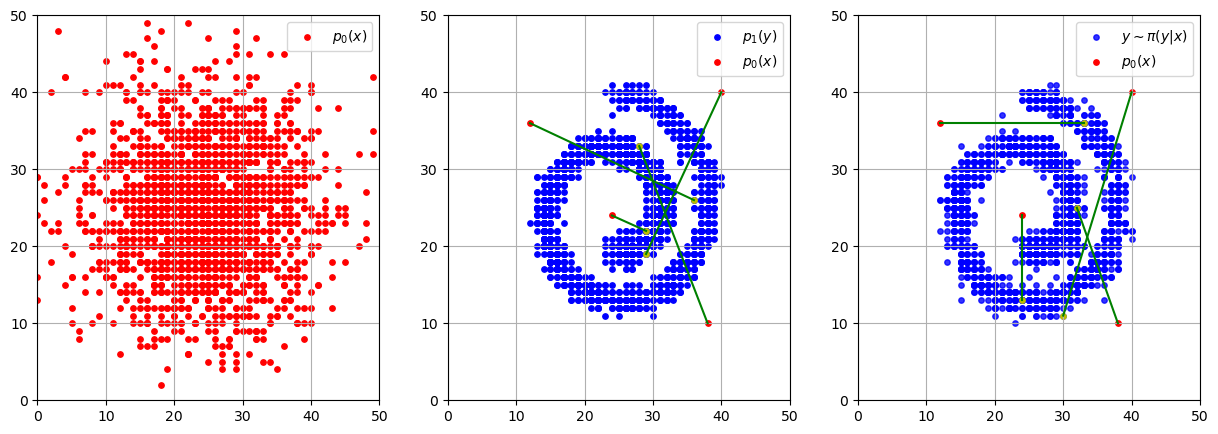

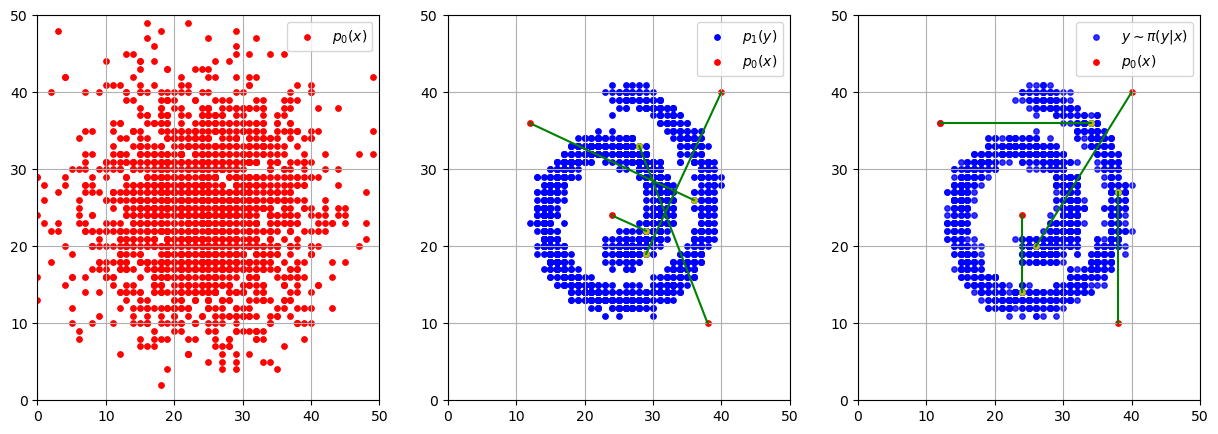

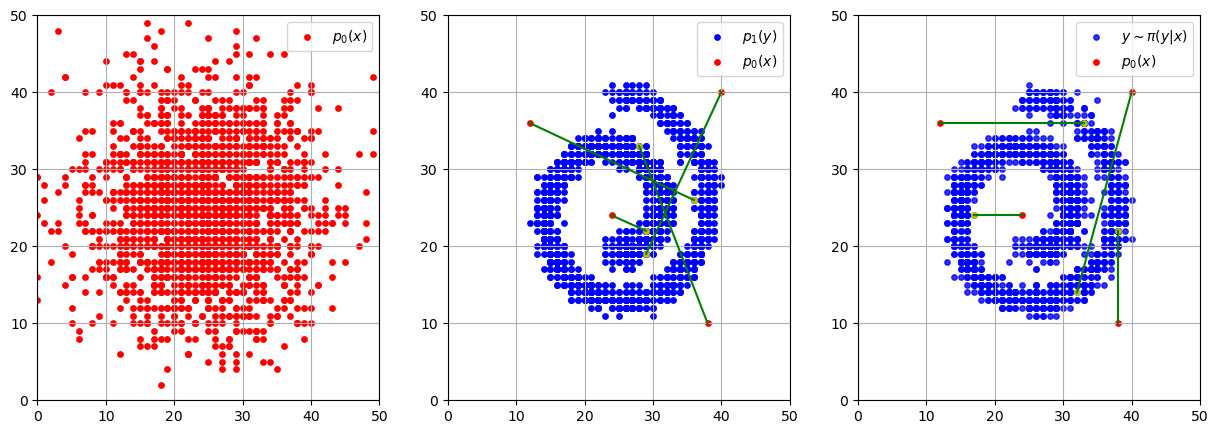

  0%|          | 0/200000 [00:00<?, ?it/s]

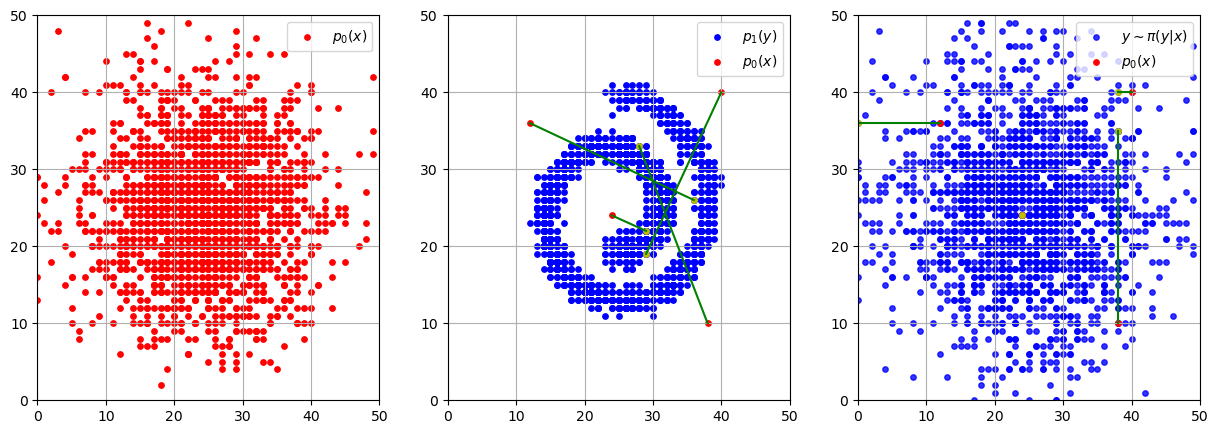

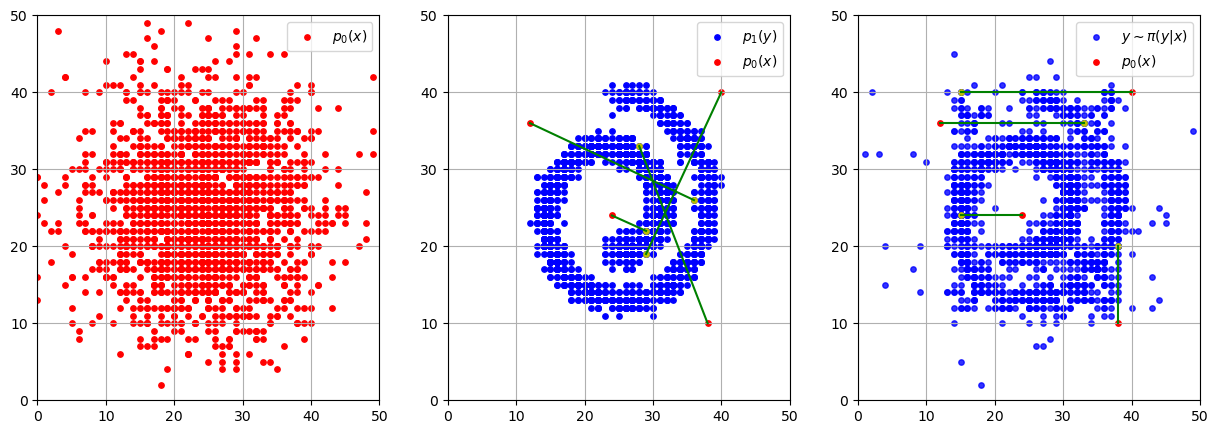

In [ ]:

xmin, xmax = 0, 50  
ymin, ymax = 0, 50  
N_TEST     = 2000

if P0 == 'gaussian':
    X0_full = DiscreteGaussianDataset(num_samples=N_TEST, dim=DIM, num_categories=N_CAT, train=False).dataset
    X1_full = DiscreteSwissRollDataset(num_samples=N_TEST, num_categories=N_CAT).dataset
if P0 == 'uniform':
    X0_full = DiscreteUniformDataset(num_samples=N_TEST, dim=DIM, num_categories=N_CAT, train=False).dataset
    X1_full = DiscreteSwissRollDataset(num_samples=N_TEST, num_categories=N_CAT).dataset
if P0 == 'benchmark':
    X0_full = torch.load('X0_benchmark_dim_2.pt')
    X1_full = torch.load('X1_benchmark_dim_2.pt')
    
X0_test =X0_full[-N_TEST:].to(torch.int32).to(DEVICE)
X1_test =X1_full[-N_TEST:].to(torch.int32).to(DEVICE)

indices_plot = torch.tensor([0, 1, 2, 3], dtype=torch.int32)#torch.randint(0, len(X0_test), (50,))

for BETA in BETAS[::-1]:
    exp_name = f'LightSB_D_beta({BETA})'
    wandb.init(name=exp_name, project=f'LightSB_D_P0_{P0}_TRANSITION({TRANSITION})' , config=config, mode=wandb_mode)
    D = LightSB_D(dim=DIM, n_cat=N_CAT, n_potentials=N_POTENTIALS, beta=BETA, transition=TRANSITION)
    
    #if INIT_BY_SAMPLES:
    #    D.init_r_by_samples(Y_sampler.sample(N_POTENTIALS))
    
    D_opt = torch.optim.Adam(D.parameters(), lr=D_LR)
    for step in tqdm(range(N_EPOCHS)):
        D.train()
        D_opt.zero_grad()    

        if P0 == 'gaussian':
            X0 = DiscreteGaussianDataset(num_samples=BATCH_SIZE, dim=DIM, num_categories=N_CAT).dataset
            X1 = DiscreteSwissRollDataset(num_samples=BATCH_SIZE, num_categories=N_CAT).dataset
        
        if P0 == 'uniform':
            X0 = DiscreteUniformDataset(num_samples=BATCH_SIZE, dim=DIM, num_categories=N_CAT).dataset
            X1 = DiscreteSwissRollDataset(num_samples=BATCH_SIZE, num_categories=N_CAT).dataset
            
        if P0 == 'benchmark':
            indices = torch.randint(high=len(X0_full)-BATCH_SIZE, size=(BATCH_SIZE,))
            X0 = X0_full[indices]
            X1 = X1_full[indices]
            
        X0 = X0.to(torch.int32).to(DEVICE)
        X1 = X1.to(torch.int32).to(DEVICE)
    
        log_potential = D.get_log_v(X1)
        log_C         = D.get_log_c(X0)
        
        D_loss = (-log_potential + log_C).mean()
        wandb.log({'D_loss':D_loss.item()}, step=step)
        D_loss.backward()
        
        D_opt.step()    
    
        if step % 50000==0 or step==N_EPOCHS-1:
            D.eval()
            predicted = D(X0_test).detach().cpu()
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].scatter(X0_test[:, 0].cpu(), X0_test[:, 1].cpu(), s=15, color='r', label=fr'$p_0(x)$')
            axes[1].scatter(X1_test[:, 0].cpu(), X1_test[:, 1].cpu(), s=15, color='b', label=fr'$p_1(y)$')
            
            axes[2].scatter(predicted[:, 0], predicted[:, 1], s=15, color='b', alpha=0.8, label=fr'$y \sim \pi(y|x)$')

            for i in indices_plot:
                axes[2].plot(
                    [X0_test[i, 0].cpu(), predicted[i, 0]],
                    [X0_test[i, 1].cpu(), predicted[i, 1]],
                    color='g',
                    linewidth=1.5,
                    alpha=1.0
                )
                axes[1].plot(
                    [X0_test[i, 0].cpu(), X1_test[i, 0].cpu()],
                    [X0_test[i, 1].cpu(), X1_test[i, 1].cpu()],
                    color='g',
                    linewidth=1.5,
                    alpha=1.0
                )
            axes[1].scatter(X0_test[indices_plot, 0].cpu(), X0_test[indices_plot, 1].cpu(), s=15, color='r', label=fr'$p_0(x)$')
            axes[1].scatter(X1_test[indices_plot, 0].cpu(), X1_test[indices_plot, 1].cpu(), s=15, color='y')
            
            axes[2].scatter(X0_test[indices_plot, 0].cpu(), X0_test[indices_plot, 1].cpu(), s=15, color='r', label=fr'$p_0(x)$')
            axes[2].scatter(predicted[indices_plot, 0].cpu(), predicted[indices_plot, 1].cpu(), s=15, color='y')
            
            
            for ax in axes:
                ax.set_xlim(xmin, xmax)
                ax.set_ylim(ymin, ymax)
                ax.legend()
                ax.grid()
                
            wandb.log({'Plot source->target' : [wandb.Image(fig2img(fig))]}, step=step)
            
            plt.show()
        

In [1]:
import torch

In [2]:
a = torch.randint(0, 10, (10,)).cuda()